VV certo

Best Portfolio for Composition Period:
Tickers: Index(['IRBR3', 'LREN3', 'BBAS3', 'YDUQ3'], dtype='object')
Weights:
IRBR3 : 1.50%
LREN3 : 22.90%
BBAS3 : 75.60%
YDUQ3 : 0.00%


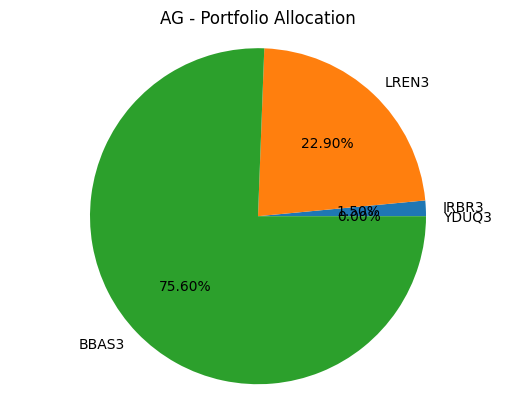

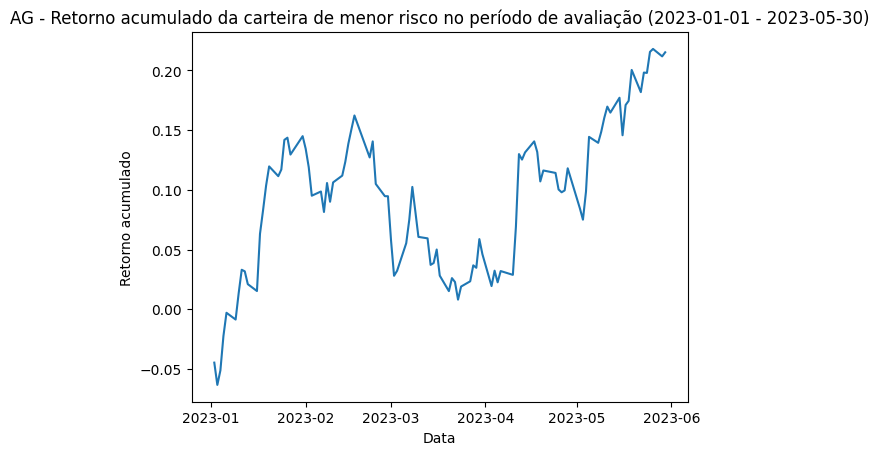

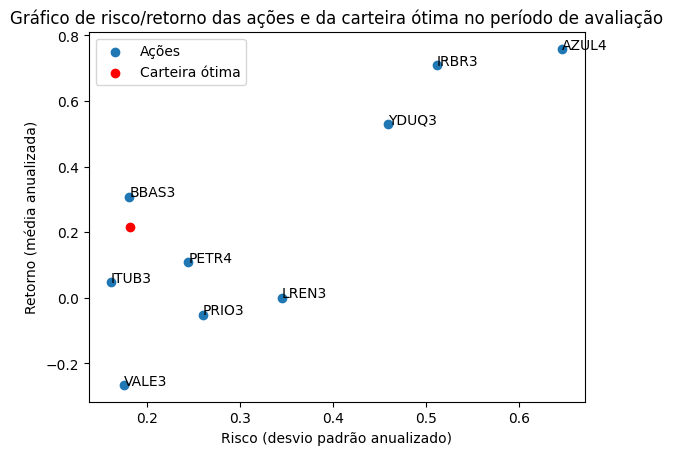

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import random
from deap import creator, base, tools, algorithms
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Carregar os dados dos retornos das ações
file_path = "Acoes.xlsx"
returns = pd.read_excel(file_path, sheet_name="retorno")

# Transformar dados em um DataFrame de séries temporais
returns = returns.set_index("Data")
returns.index = pd.to_datetime(returns.index, format="%d/%m/%Y")
returns.columns = returns.columns.map(lambda x: x.replace(" ", ""))

# Definir períodos de composição e avaliação das carteiras
start_date_composition = datetime.strptime("01/01/2021", "%d/%m/%Y")
end_date_composition = datetime.strptime("31/12/2022", "%d/%m/%Y")
start_date_evaluation = datetime.strptime("01/01/2023", "%d/%m/%Y")
end_date_evaluation = datetime.strptime("30/05/2023", "%d/%m/%Y")

# Filtrar retornos para o período de composição das carteiras
returns_composition = returns.loc[start_date_composition:end_date_composition]

# Filtrar retornos para o período de avaliação das carteiras
returns_evaluation = returns.loc[start_date_evaluation:end_date_evaluation]

# Definir parâmetros do algoritmo genético
pop_size = 200  # Tamanho da população
max_iterations = 1000  # Número máximo de iterações
mutation_prob = 0.01  # Probabilidade de mutação
crossover_prob = 0.8  # Probabilidade de crossover

# Função de fitness (retorno médio e risco)
def fitness_function(chromosome):
    returns_selected = returns_composition.loc[:, chromosome.astype(bool)]
    mean_return = returns_selected.mean().mean()
    std_return = returns_selected.std().mean()
    return mean_return, std_return

# Definir o tipo de problema (minimização ou maximização)
creator.create("FitnessMin", base.Fitness, weights=(-1.0, 1.0))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

# Inicialização da população
def initialize_population(chromosome_length):
    return [creator.Individual(np.random.choice([False, True], size=chromosome_length)) for _ in range(pop_size)]

# Algoritmo genético para otimização da carteira
best_portfolio = None
best_fitness = (np.inf, np.inf)

# Definir as ferramentas do algoritmo genético
toolbox = base.Toolbox()
toolbox.register("evaluate", fitness_function)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=mutation_prob)
toolbox.register("select", tools.selTournament, tournsize=3)

# Executar o algoritmo genético
pop = initialize_population(len(returns.columns))

for iteration in range(max_iterations):
    offspring = algorithms.varAnd(pop, toolbox, cxpb=crossover_prob, mutpb=mutation_prob)
    fits = toolbox.map(toolbox.evaluate, offspring)
    
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    
    pop = toolbox.select(offspring + pop, k=pop_size)
    
    if min(pop, key=lambda x: x.fitness.values).fitness.values < best_fitness:
        best_portfolio = min(pop, key=lambda x: x.fitness.values)
        best_fitness = best_portfolio.fitness.values

# Melhor carteira
best_portfolio_mask = best_portfolio.astype(bool)
best_portfolio_tickers = returns.columns[best_portfolio_mask]
returns_selected = returns_composition.loc[:, best_portfolio_tickers]
best_portfolio_returns = returns_selected.mean()
best_portfolio_std = returns_selected.std()

# Calcular os pesos da carteira ideal
returns_composition_selected = returns_composition.loc[:, best_portfolio_tickers]
cov_matrix = returns_composition_selected.cov()
inv_cov_matrix = np.linalg.inv(cov_matrix)

weights = np.ones(len(best_portfolio_tickers))  # vetor inicial de pesos
weights /= np.sum(weights)  # normalização dos pesos
weights = weights @ inv_cov_matrix  # multiplicação matricial pelos pesos ótimos
weights -= np.min(weights)  # garantir que os pesos sejam não negativos
weights /= np.sum(weights)  # normalização dos pesos novamente

# Imprimir alocação ideal
print("Best Portfolio for Composition Period:")
print("Tickers:", best_portfolio_tickers)
print("Weights:")
for ticker, weight in zip(best_portfolio_tickers, weights):
    print(ticker, ": {:.2%}".format(weight))

# Calcular os retornos diários do novo portfólio durante o período de avaliação
returns_portfolio_evaluation = returns_evaluation[best_portfolio_tickers] * weights
returns_portfolio_evaluation["Portfolio"] = returns_portfolio_evaluation.sum(axis=1)

# Plotar gráfico de pizza
plt.pie(weights, labels=best_portfolio_tickers, autopct="%.2f%%")
plt.title("AG - Portfolio Allocation")
plt.axis("equal")
plt.show()

# Calculando o valor da carteira ótima no período de avaliação, considerando d0=1
cumulative_returns_portfolio = (1 + returns_portfolio_evaluation["Portfolio"]).cumprod() - 1
plt.plot(cumulative_returns_portfolio)
plt.xlabel("Data")
plt.ylabel("Retorno acumulado")
plt.title(f"AG - Retorno acumulado da carteira de menor risco no período de avaliação ({start_date_evaluation.date()} - {end_date_evaluation.date()})")
plt.show()

# Calculando a média e o desvio padrão dos retornos diários das ações no período de avaliação
media_eval = returns_evaluation.mean()
desvio_eval = returns_evaluation.std()
# Calculando a matriz de covariância dos retornos diários das ações no período de avaliação
covariancia_eval = returns_evaluation.cov()

# Calcular o risco e o retorno do período considerado das ações e da carteira ótima no período de avaliação
risco_acoes_eval = desvio_eval * np.sqrt(len(returns_evaluation))
retorno_acoes_eval = np.power(1 + media_eval, len(returns_evaluation)) - 1

covariancia_eval_selected = covariancia_eval.loc[best_portfolio_tickers, best_portfolio_tickers]
risco_carteira_eval = np.sqrt(weights @ covariancia_eval_selected @ weights) * np.sqrt(len(returns_evaluation))

retorno_carteira_total = (1 + returns_portfolio_evaluation["Portfolio"]).prod() - 1

# Plotando um gráfico de dispersão com o risco e o retorno das ações e da carteira ótima no período de avaliação
plt.scatter(risco_acoes_eval, retorno_acoes_eval, label="Ações")
plt.scatter(risco_carteira_eval, retorno_carteira_total, color="red", label="Carteira ótima")
plt.xlabel("Risco (desvio padrão anualizado)")
plt.ylabel("Retorno (média anualizada)")
plt.title("Gráfico de risco/retorno das ações e da carteira ótima no período de avaliação")
plt.legend()

# Adicionando o nome das ações em cada ponto
for i in range(len(returns.columns)):
    plt.annotate(returns.columns[i], (risco_acoes_eval[i], retorno_acoes_eval[i]))

plt.show()

O vetor de pesos ótimo é: PETR4    0.000000
VALE3    0.393817
AZUL4    0.000000
IRBR3    0.000000
LREN3    0.000000
BBAS3    0.599593
ITUB3    0.000000
PRIO3    0.006590
YDUQ3    0.000000
dtype: float64
O valor mínimo da função objetivo é: 0.0002844703650469292
O número de iterações realizadas foi: 100000


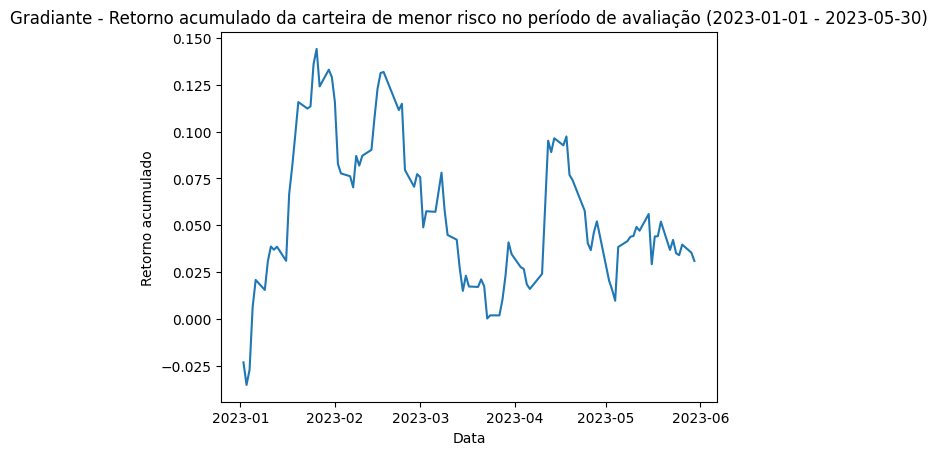

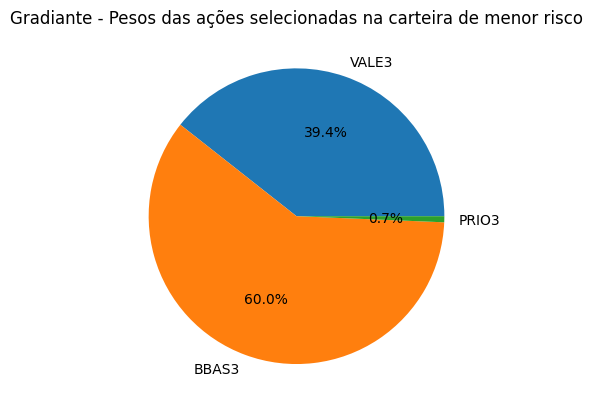

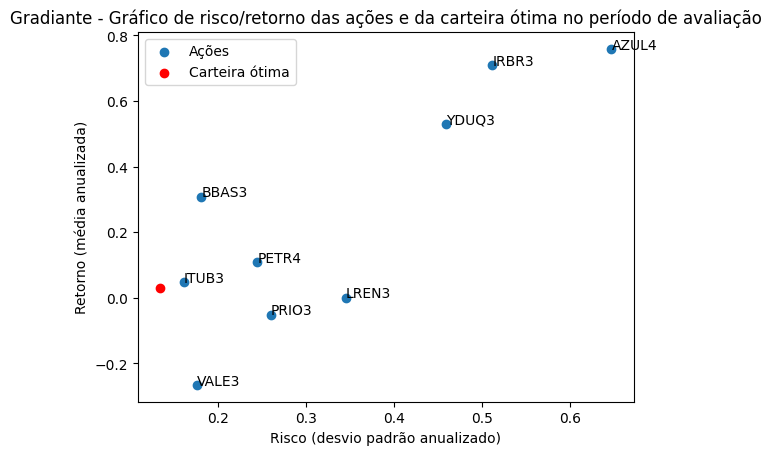

In [ ]:
# Importando as bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Definindo os parâmetros do problema
n = 9  # Número de ações na carteira
T = 252  # Número de dias úteis no ano
r = 0.1375 / T  # Taxa livre de risco diária
alpha = 0.01  # Taxa de aprendizado do método do gradiente

# Carregar os dados dos retornos das ações
file_path = "Acoes.xlsx"
returns = pd.read_excel(file_path, sheet_name="retorno")

# Transformar dados em um DataFrame de séries temporais
returns = returns.set_index("Data")
returns.index = pd.to_datetime(returns.index, format="%d/%m/%Y")
returns.columns = returns.columns.map(lambda x: x.replace(" ", ""))

# Definir períodos de composição e avaliação das carteiras
start_date_composition = datetime.strptime("01/01/2021", "%d/%m/%Y")
end_date_composition = datetime.strptime("31/12/2022", "%d/%m/%Y")
start_date_evaluation = datetime.strptime("01/01/2023", "%d/%m/%Y")
end_date_evaluation = datetime.strptime("30/05/2023", "%d/%m/%Y")

# Filtrar retornos para o período de composição das carteiras
returns_composition = returns.loc[start_date_composition:end_date_composition]

# Filtrar retornos para o período de avaliação das carteiras
returns_evaluation = returns.loc[start_date_evaluation:end_date_evaluation]

# Calculando a média e o desvio padrão dos retornos diários das ações no período de composição
media = returns_composition.mean()
desvio = returns_composition.std()
# Calculando a matriz de covariância dos retornos diários das ações no período de composição
covariancia = returns_composition.cov()

# Definindo a função objetivo a ser minimizada
# A função objetivo é o risco da carteira (variância)
def funcao_objetivo(x):
    return x.T @ covariancia @ x

# Definindo o gradiente da função objetivo
def gradiente(x):
    return 2 * covariancia @ x

# Inicializando o vetor de pesos da carteira com valores aleatórios
# Os pesos devem somar 1 e ser não negativos
x = np.random.rand(n)
x = x / x.sum()

# Inicializando uma lista para armazenar os valores da função objetivo em cada iteração
fval = []

# Aplicando o método do gradiente até atingir um critério de parada
# O critério de parada pode ser um número máximo de iterações ou uma tolerância para o gradiente
max_iter = 100000  # Número máximo de iterações
tol = 1e-6  # Tolerância para o gradiente
iter = 0  # Contador de iterações
while iter < max_iter and np.linalg.norm(gradiente(x)) > tol:
    # Atualizando o vetor de pesos na direção negativa do gradiente
    x = x - alpha * gradiente(x)
    # Projetando o vetor de pesos no conjunto factível (soma 1 e não negativo)
    x = np.maximum(x, 0)
    x = x / x.sum()
    # Calculando o valor da função objetivo no ponto atual
    fval.append(funcao_objetivo(x))
    # Incrementando o contador de iterações
    iter += 1

# Imprimindo o resultado final
print(f"O vetor de pesos ótimo é: {x}")
print(f"O valor mínimo da função objetivo é: {fval[-1]}")
print(f"O número de iterações realizadas foi: {iter}")

# Calculando os retornos da carteira ótima no período de avaliação
retornos_carteira = returns_evaluation @ x

# Calculando o valor da carteira ótima no período de avaliação, considerando d0=1
cumulative_returns_portfolio = (1 + retornos_carteira).cumprod() - 1
plt.plot(cumulative_returns_portfolio)
plt.xlabel("Data")
plt.ylabel("Retorno acumulado")
plt.title(f"Gradiante - Retorno acumulado da carteira de menor risco no período de avaliação ({start_date_evaluation.date()} - {end_date_evaluation.date()})")
plt.show()

# Filtrando os pesos das ações que foram selecionadas na carteira ótima (maiores que zero)
pesos_selecionados = x[x > 0]
acoes_selecionadas = returns.columns[x > 0]

# Plotando um gráfico de pizza com os pesos das ações selecionadas na carteira ótima
plt.pie(pesos_selecionados, labels=acoes_selecionadas, autopct="%1.1f%%")
plt.title("Gradiante - Pesos das ações selecionadas na carteira de menor risco")
plt.show()

# Calculando a média e o desvio padrão dos retornos diários das ações no período de avaliação
media_eval = returns_evaluation.mean()
desvio_eval = returns_evaluation.std()
# Calculando a matriz de covariância dos retornos diários das ações no período de avaliação
covariancia_eval = returns_evaluation.cov()

# Calculando o risco e o retorno do período considerado das ações e da carteira ótima no período de avaliação
risco_acoes_eval = desvio_eval * np.sqrt(len(returns_evaluation))
retorno_acoes_eval = np.power(1 + media_eval, len(returns_evaluation)) - 1
risco_carteira_eval = np.sqrt(x.T @ covariancia_eval @ x) * np.sqrt(len(returns_evaluation))
retorno_carteira_total = (1 + retornos_carteira).prod() - 1

# Plotando um gráfico de dispersão com o risco e o retorno das ações e da carteira ótima no período de avaliação
plt.scatter(risco_acoes_eval, retorno_acoes_eval, label="Ações")
plt.scatter(risco_carteira_eval, retorno_carteira_total, color="red", label="Carteira ótima")
plt.xlabel("Risco (desvio padrão anualizado)")
plt.ylabel("Retorno (média anualizada)")
plt.title("Gradiante - Gráfico de risco/retorno das ações e da carteira ótima no período de avaliação")
plt.legend()
# Adicionando o nome das ações em cada ponto
for i in range(n):
    plt.annotate(returns.columns[i], (risco_acoes_eval[i], retorno_acoes_eval[i]))
plt.show()